# Titanic EDA V2 - Feature Analysis for Modeling
This notebook evaluates new engineered features intended for inclusion in the v2 model.  
It builds upon the previous EDA (`eda_titanic_v1_based_on_raw_data_2025-07-21.ipynb`) and focuses on analyzing the predictive potential of custom-created features.  

## Goals

- Visualize the distribution of engineered features
- Understand their correlation with the target (`Survived`)
- Decide whether they are useful for modeling

## Table of Content

1. **Import Dependencies & Load Dataset** 載入套件與資料
2. **Planned Feature Analysis List** 特徵列表與預計分析順序
3. **Feature Engineering** 特徵工程
   - 3.1 Title (from Name)
     - 3.1-1 Title_Grouped
   - 3.2 FamilySize (= SibSp + Parch + 1)
     - 3.2-1 FamilyGroup
   - 3.3 IsAlone (derived from FamilySize)
   - 3.4 FarePerPerson (= Fare / FamilySize)
   - 3.5 Deck (extracted from Cabin)
   - 3.6 Embarked
4. **Final Feature Summary & Export**
   - Final feature list
   - Save feature-enhanced dataset
5. **Archived**
   - Deck Cross-Feature Analysis (Excluded from Modeling)
       - Deck × Pclass
       - Deck × Pclass × Survival
       - Deck × FarePerPerson *(considered but excluded)*
   - 3.5-1 PremiumCabin (Excluded from Modeling)
   - Embarked Cross-Feature Analysis (Excluded from Modeling)

## 1. Import Dependencies & Load Dataset 載入套件與資料

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 載入原始資料
train = pd.read_csv("../data/train.csv")
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. Planned Feature Analysis List 特徵列表與預計分析順序

We will evaluate the following features one by one:  
1. `Title` - extracted from `Name`
2. `FamilySize` - SibSp + Parch + 1
3. `IsAlone` - binary version of FamilySize
4. `FarePerPerson` - Fare / FamilySize
5. `Deck` - extracted from Cabin (optional)  

Each feature will be analyzed by:
- Value distribution (univariate)
- Survival rate correlation (bivariate)
- Potential issues (skewed classes, missing values, etc.)

**Note on Previously Analyzed Features:**  
The following features were already thoroughtly analyzed in **EDA V1** and will note be repeated in EDA V2:  
- `Sex` - Strong correlation with survival. Females had significantly higher survival rates.
- `Pclass` - Lower-class passengers (Pclass = 3) had much lower survival rates.
- `Age` - Distribution showed bimodality and non-survival skew toward adults. Some missing values were also noted.

These features will be directly considered for modeling in V2 without redundant analysis here,.

## 3. Feature Engineering 特徵工程

### 3.1 `Title`

In [2]:
# 萃取 Title
def extract_title(name):
    return name.split(',')[1].split('.')[0].strip()

train['Title'] = train['Name'].apply(extract_title)

print(train['Title'].value_counts())

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64


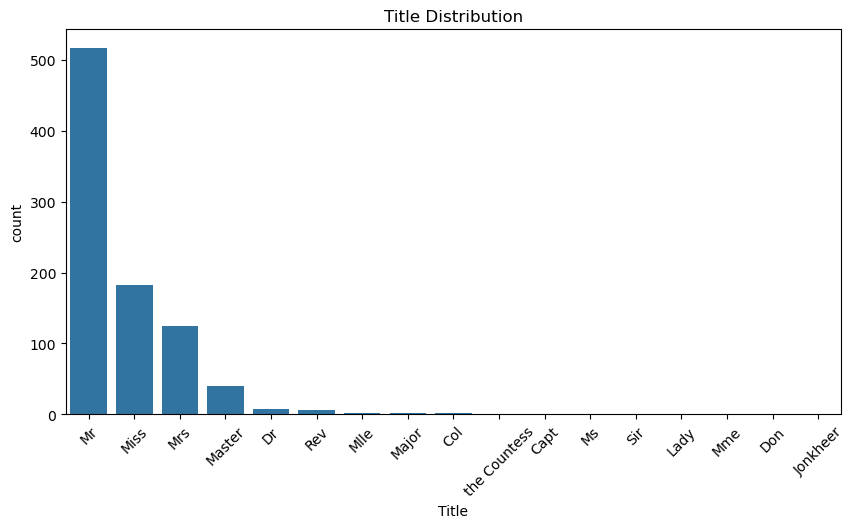

In [3]:
# 視覺化 Title 的分佈
plt.figure(figsize=(10,5))
sns.countplot(data=train, x='Title', order=train['Title'].value_counts().index)
plt.title('Title Distribution')
plt.xticks(rotation=45)
plt.show()

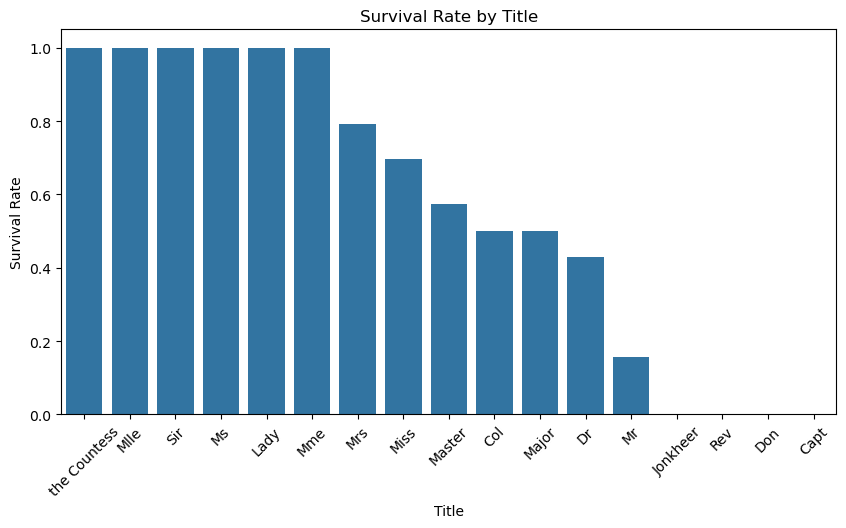

In [4]:
# Title 與生還率的關係
title_survival = train.groupby('Title')['Survived'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=title_survival.index, y=title_survival.values)
plt.title('Survival Rate by Title')
plt.ylabel('Survival Rate')
plt.xticks(rotation=45)
plt.show()

#### Summary: Insights on `Title`
- The most common titles are `Mr`, `Miss` and `Mrs`.  
- Rare titles such as `Don`, `Rev`, `Jonkheer`, `Capt`, `Sir`, `Countess`, and `Lady` appear very infrequently (fewer than 10 times).  
- Some rare titles like `Countess` and `Mme` show high survival rates, but the sample sizes are too small to draw meaningful conclustions.  

**Conclusion:** To prevent model distortion caused by infrequent categoriesm we will group all titles that occur fewer than 10 times into a single category called `Rare`. We will continue with this analysis in section **3.1-1** `Title_Grouped`.  

### 3.1-1 `Title_Grouped`

In [5]:
# 萃取 Title
def extract_title(name):
    return name.split(',')[1].split('.')[0].strip()

train['Title'] = train['Name'].apply(extract_title)

# 建立 Title_Grouped 欄位
# 找出所有出現次數少於 10 的 Title
title_counts = train['Title'].value_counts()
rare_titles = title_counts[title_counts < 10].index.tolist()

# 建立新欄位 Title_Grouped，將稀有稱謂歸為 Rare
train['Title_Grouped'] = train['Title'].apply(lambda x: 'Rare' if x in rare_titles else x)

# 看看分組後有哪些 Title
print(train['Title_Grouped'].value_counts())

Title_Grouped
Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: count, dtype: int64


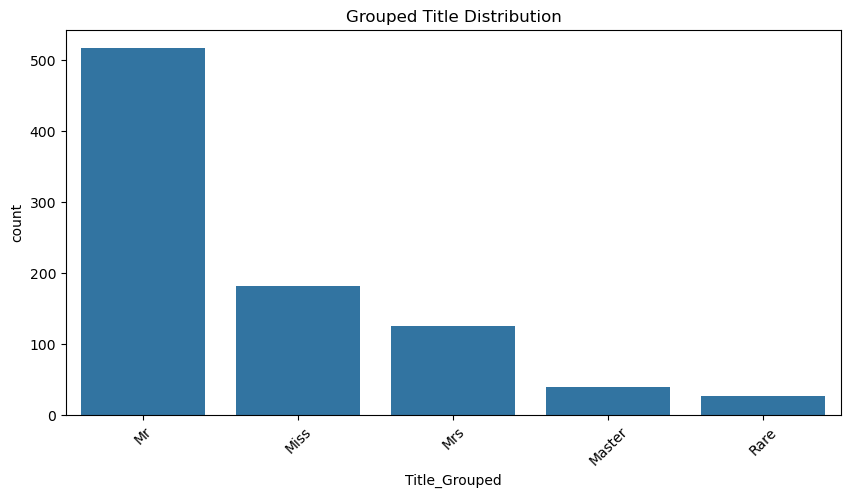

In [6]:
# 視覺化 Grouped Title 的分佈
plt.figure(figsize=(10,5))
sns.countplot(data=train, x='Title_Grouped', order=train['Title_Grouped'].value_counts().index)
plt.title('Grouped Title Distribution')
plt.xticks(rotation=45)
plt.show()

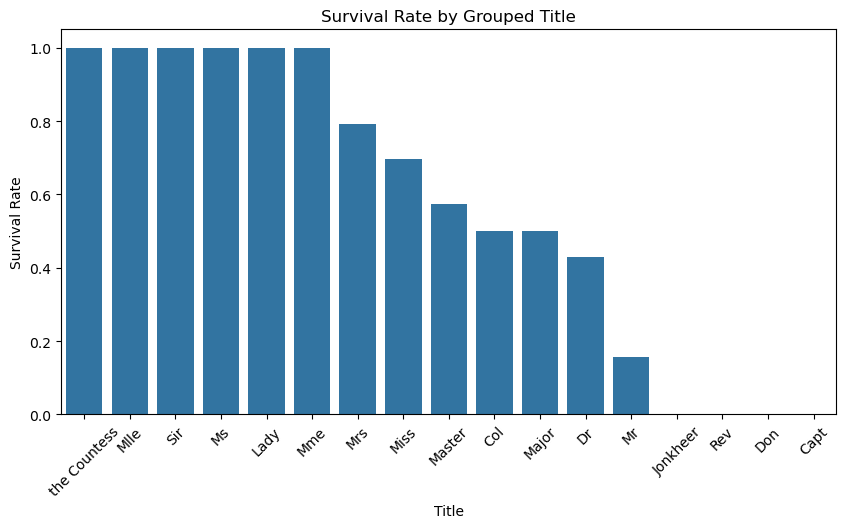

In [7]:
# Grouped Title 與生還率的關係
title_grouped_survival = train.groupby('Title_Grouped')['Survived'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=title_survival.index, y=title_survival.values)
plt.title('Survival Rate by Grouped Title')
plt.ylabel('Survival Rate')
plt.xticks(rotation=45)
plt.show()

In [8]:
title_grouped_survival

Title_Grouped
Mrs       0.792000
Miss      0.697802
Master    0.575000
Rare      0.444444
Mr        0.156673
Name: Survived, dtype: float64

#### Summary: Insights on `Title_Grouped`
- `Mrs` has the highest survival rate at **79.2%**, followed by `Miss` (**69.8%**) and `Master` (**57.5%**).
- `Rare` titles have a moderate survival rate of **44.4%**, indicating some signal but less consistency.
- `Mr` has the lowest survival rate at **15.7%**, suggesting strong correlation with non-survival.

**Conclustion:** `Title_Grouped` demonstrates a clear relationship with survival outcome. This variable will be **retianed as a categorical feature** for model training.

In [64]:
# ✅ 新增 Title_Grouped 欄位（以納入模型訓練）
def extract_title(name):
    return name.split(',')[1].split('.')[0].strip()

# 萃取 Title
train['Title'] = train['Name'].apply(extract_title)

# 分群為 Title_Grouped（將出現次數少於 10 的視為 Rare）
title_counts = train['Title'].value_counts()
rare_titles = title_counts[title_counts < 10].index.tolist()
train['Title_Grouped'] = train['Title'].apply(lambda x: 'Rare' if x in rare_titles else x)

### 3.2 `FamilySize` (= SibSp + Parch + 1)

In [9]:
# 建立 FamilySize 欄位 : 兄弟姐妹 + 父母子女 + 自己
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1

# 確認新增欄位
train[['SibSp', 'Parch', 'FamilySize']].head()

,SibSp,Parch,FamilySize
0,1,0,2
1,1,0,2
2,0,0,1
3,1,0,2
4,0,0,1


In [10]:
# 檢查整體資料分布 (列出每個 FamilySize 的人數統計)
train['FamilySize'].value_counts().sort_index()

FamilySize
1     537
2     161
3     102
4      29
5      15
6      22
7      12
8       6
11      7
Name: count, dtype: int64

In [11]:
# 驗證 FamilySize 人數總和‘是否等於訓練資料總筆數
print("FamilySize總計: ", train['FamilySize'].value_counts().sum())
print("訓練資料總筆數: ", train.shape[0])
print("是否一致? ", train['FamilySize'].value_counts().sum() == train.shape[0])

FamilySize總計:  891
訓練資料總筆數:  891
是否一致?  True


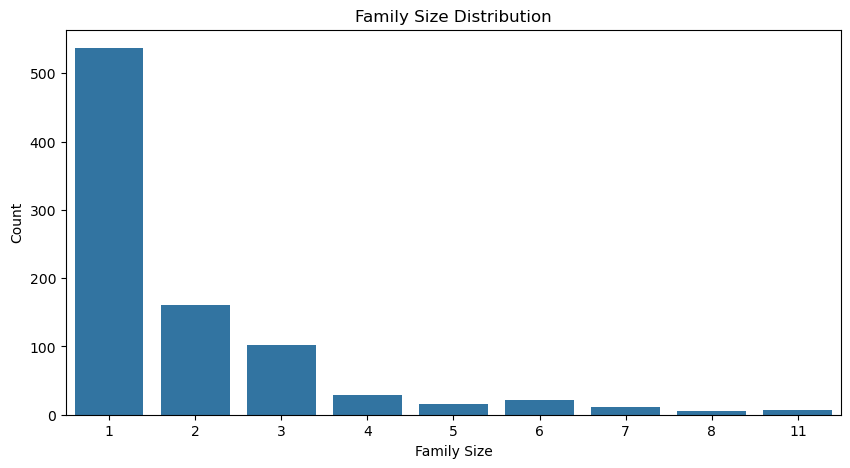

In [12]:
# 視覺化 FamilySize
plt.figure(figsize=(10, 5))
sns.countplot(data=train, x='FamilySize')
plt.title('Family Size Distribution')
plt.xlabel('Family Size')
plt.ylabel('Count')
plt.show()

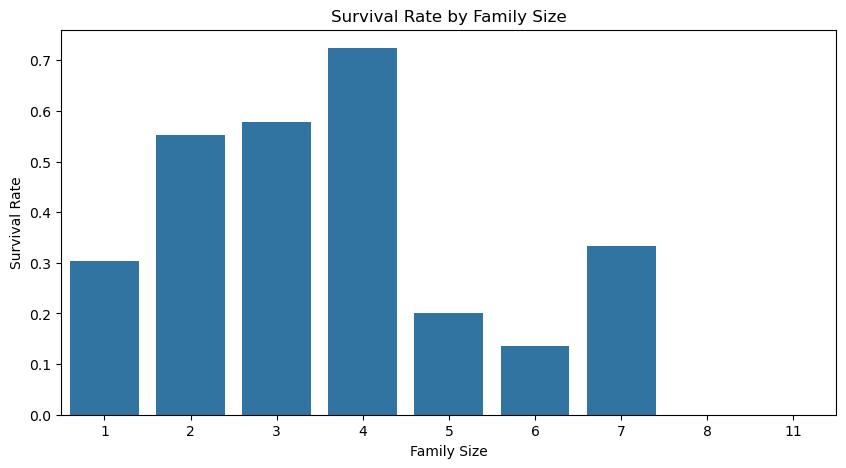

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [13]:
# FamilySize 與生還率的關係
family_survival = train.groupby('FamilySize')['Survived'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=family_survival, x='FamilySize' , y='Survived')
plt.title('Survival Rate by Family Size')
plt.xlabel('Family Size')
plt.ylabel('Survival Rate')
plt.show()

family_survival

### 3.2-1 `FamilyGroup` (將FamilySize分類)

#### 建立FamilyGroup分類邏輯:
|FamilySize Range|Group|
|:-|:-|
|1|Alone (單獨)|
|2~4|Small (小家庭)|
|5+|Large (大家庭)|

In [14]:
# 建立 FamilyGroup 欄位
def group_family(size):
    if size == 1:
        return 'Alone'
    elif 2 <= size <= 4:
        return 'Small'
    else:
        return 'Large'

train['FamilyGroup'] = train['FamilySize'].apply(group_family)

# 檢查每組分類人數分佈
train['FamilyGroup'].value_counts()

FamilyGroup
Alone    537
Small    292
Large     62
Name: count, dtype: int64

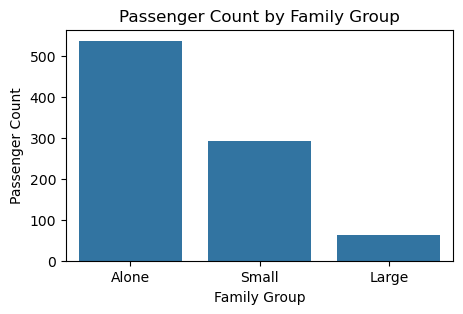

In [15]:
# 視覺化 FamilyGroup
plt.figure(figsize=(5,3))
sns.countplot(data=train, x='FamilyGroup', order=['Alone', 'Small', 'Large'])
plt.title('Passenger Count by Family Group')
plt.xlabel('Family Group')
plt.ylabel('Passenger Count')
plt.show()

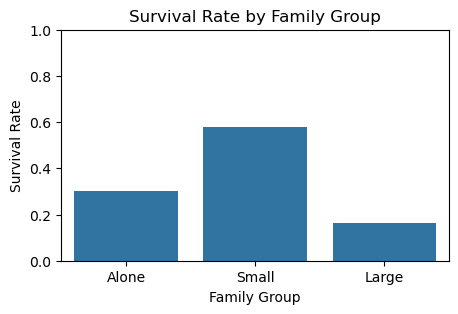

In [16]:
# FamilyGroup 與生還率的關係
group_survival = train.groupby('FamilyGroup')['Survived'].mean().reset_index()

plt.figure(figsize=(5,3))
sns.barplot(data=group_survival, x='FamilyGroup', y='Survived', order=['Alone', 'Small', 'Large'])
plt.title('Survival Rate by Family Group')
plt.xlabel('Family Group')
plt.ylabel('Survival Rate')
plt.ylim(0,1)
plt.show()

#### Summary: Family Size & Family Group Analysis
Based on the distribution and survival rates:  
- **Solo travelers (FamilySize = 1)** represent the largest group and exhibit a relatively low servival rate (~30%).
- **Small families (FamilySize = 2~4)** not only form the second-largest group but also achieve the **highest survival rate** (~55-60%).
- **Large families (FamilySize ≥ 5)** have the **lowest survival rate**, but their population size is limited (~60 passengers), so this insight should be interpreted with caution.

> While these patterns are informative, further statistical validation (e.g., confidence intervals) may be considered to confirm robustness.

目前我們看到的是「平均生還率的差異」，但我們還沒判斷這些差異是不是因為隨機誤差造成的。為了得到更嚴謹的判斷結果，需要「統計檢定」。

#### 3.2-1 (1) 卡方檢定 - `FamilyGroup` vs `FamilySize`

In [17]:
# 卡方檢定 - FamilyGroup vs Survived
from scipy.stats import chi2_contingency

# 製作交叉表
contingency_table = pd.crosstab(train['FamilyGroup'], train['Survived'])

# 執行卡方檢定
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared: {chi2:.2f}")
print(f"p-value: {p:.4f}")

# 如果 p < 0.05 ，就表示: FamilyGroup 與 Survived 間存在顯著關聯，差異非偶然。

Chi-squared: 74.54
p-value: 0.0000


#### 3.2-1 (2) 信賴區間 - 用`proportion_confint()`

In [18]:
# 信賴區間 - 用 proportion_confint()
from statsmodels.stats.proportion import proportion_confint

# 每組的生還人數與總人數
group_counts = train.groupby('FamilyGroup')['Survived'].agg(['sum', 'count'])

# 加入信賴區間
group_counts['lower_ci'], group_counts['upper_ci'] = proportion_confint(
    count=group_counts['sum'],
    nobs=group_counts['count'],
    alpha=0.05,  # 95%信賴區間
    method='wilson'
)

group_counts[['sum', 'count', 'lower_ci', 'upper_ci']]


,sum,count,lower_ci,upper_ci
FamilyGroup,,,,
Alone,163,537,0.266159,0.343708
Large,10,62,0.090041,0.272063
Small,169,292,0.521471,0.634018


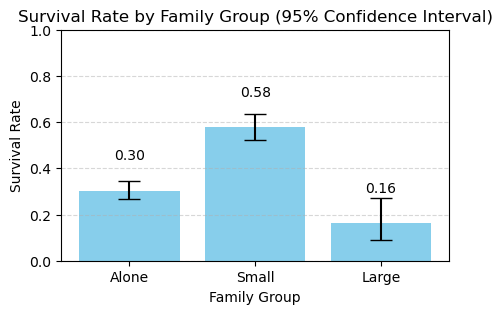

In [19]:
import matplotlib.pyplot as plt

# 確保 group_counts 有 reset index 並加上平均生還率
group_counts = group_counts.reset_index()
group_counts['mean'] = group_counts['sum'] / group_counts['count']
group_counts['error_lower'] = group_counts['mean'] - group_counts['lower_ci']
group_counts['error_upper'] = group_counts['upper_ci'] - group_counts['mean']

# 指定順序
order = ['Alone', 'Small', 'Large']
ordered_data = group_counts.set_index('FamilyGroup').loc[order].reset_index()

# Plot
plt.figure(figsize=(5, 3))
plt.bar(
    ordered_data['FamilyGroup'],
    ordered_data['mean'],
    yerr=[ordered_data['error_lower'], ordered_data['error_upper']],
    capsize=8,
    color='skyblue'
)
plt.title('Survival Rate by Family Group (95% Confidence Interval)')
plt.xlabel('Family Group')
plt.ylabel('Survival Rate')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 加入數值標籤
for index, row in ordered_data.iterrows():
    plt.text(index, row['mean'] + 0.12, f"{row['mean']:.2f}", 
             ha='center', va='bottom', fontsize=10)


plt.show()

#### Summary:
**FamilySize** (SibSp + Parch + 1) reflects the total number of family members aboard.  
- Individuals with a **family size of 2~4** had the **highest survival rates**.
- Those traveling **alone** or in **large families (≥5)** had notably **lower survival rate**.

**FamilyGroup**, a categorized feature based on FamilySize (`Alone`, `Small`, `Large`), shows:
- **Small families** had significantly higher survival rates with narrow confidence intervals.
- **Large groups** had the lowest survival rate, though uncertanty is higher due to fewer samples.
- **Alone** travelers consistently showed lower survival rates.  

**Conclution:**  
- `FamilySize` as a **numberical feature**
- `FamilyGroup` as a **categorical feature** (e.g., one-hot encoding)  
> They provide **complementary information** and are likely to improve model performance.

### 3.3 `IsAlone`

Although `FamilySize` and `FamilyGroup` already capture family-related patterns, `IsAlone` as a binary feature (alone vs. not alone) directly isolates the effect of being completely alone, which can have a strong predictive signal. Therefore, it's worth analyzing separately.

In [20]:
# 建立欄位
train['IsAlone'] = (train['FamilySize'] == 1).astype(int)

# 確認分佈與生還率
print(train['IsAlone'].value_counts())
print(train.groupby('IsAlone')['Survived'].mean())

IsAlone
1    537
0    354
Name: count, dtype: int64
IsAlone
0    0.505650
1    0.303538
Name: Survived, dtype: float64


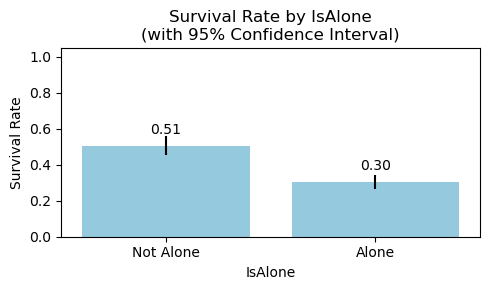

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint

# 聚合資料
isalone_group = train.groupby('IsAlone')['Survived'].agg(['sum', 'count'])
isalone_group['rate'] = isalone_group['sum'] / isalone_group['count']
isalone_group['lower_ci'], isalone_group['upper_ci'] = proportion_confint(
    count=isalone_group['sum'],
    nobs=isalone_group['count'],
    alpha=0.05,
    method='wilson'
)

# 整理為繪圖用的 DataFrame
plot_df = isalone_group.reset_index()
plot_df['IsAlone'] = plot_df['IsAlone'].map({0: 'Not Alone', 1: 'Alone'})

# 繪圖
plt.figure(figsize=(5, 3))
barplot = sns.barplot(
    data=plot_df,
    x='IsAlone',
    y='rate',
    yerr=[
        plot_df['rate'] - plot_df['lower_ci'],
        plot_df['upper_ci'] - plot_df['rate']
    ],
    capsize=0.15,
    color='skyblue'
)

# 加上生還率數值標籤
for index, row in plot_df.iterrows():
    barplot.text(index, row['rate'] + 0.05, f"{row['rate']:.2f}", 
                 ha='center', va='bottom', fontsize=10)

plt.title('Survival Rate by IsAlone\n(with 95% Confidence Interval)')
plt.ylabel('Survival Rate')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

The survival rates shown in the plot represent within-group probabilities, not proportions of the entire dataset.  
Therefore, they do not sum to 100% — and they shouldn’t.

#### Summary:
The analysis of the IsAlone feature shows that passengers who were not alone had a significantly higher survival rate compared to those who traveled alone.
This suggests that being with family or companions may have increased the chance of survival.

### 3.4 `FarePerPerson`

In [22]:
# 建立 FarePerPerson 欄位
train['FarePerPerson'] = train['Fare'] / train['FamilySize']

# 檢查欄位是否存在
print('FarePerPerson' in train.columns)  # 應顯示 True

# 顯示前幾筆資料確認數值有算出來
train[['Fare', 'FamilySize', 'FarePerPerson']].head()

True


,Fare,FamilySize,FarePerPerson
0,7.2500,2,3.62500
1,71.2833,2,35.64165
2,7.9250,1,7.92500
3,53.1000,2,26.55000
4,8.0500,1,8.05000


0
count    891.000000
mean      19.916375
std       35.841257
min        0.000000
25%        7.250000
50%        8.300000
75%       23.666667
max      512.329200
Name: FarePerPerson, dtype: float64


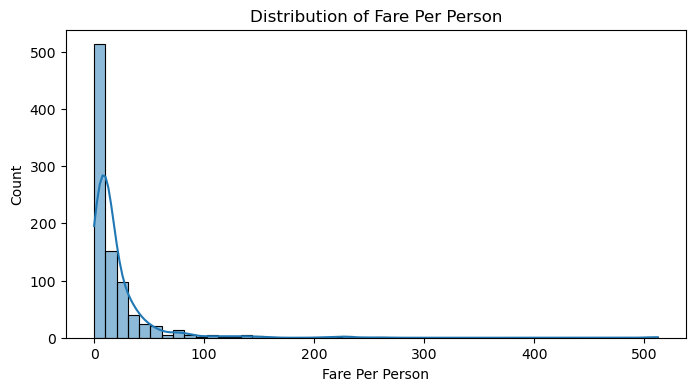

In [23]:
# 檢查有無遺失值或不合理值 (例如除以零)

# 確認是否有 NaN
print(train['FarePerPerson'].isnull().sum())

# 查看是否有極端小或負數值
print(train['FarePerPerson'].describe())

# 圖表呈現分佈
plt.figure(figsize=(8,4))
sns.histplot(train['FarePerPerson'], bins=50, kde=True)
plt.title('Distribution of Fare Per Person')
plt.xlabel('Fare Per Person')
plt.show()

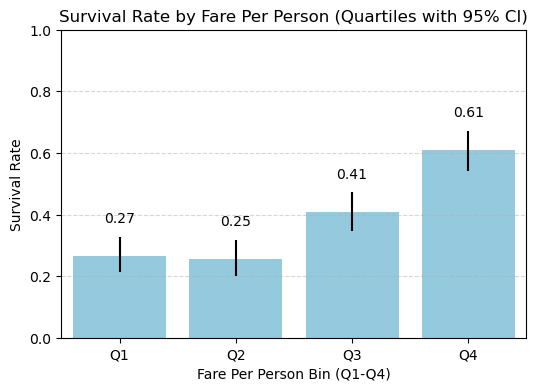

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint

# Step 1：計算每人票價，並進行四分位數分箱
train['FarePerPerson'] = train['Fare'] / train['FamilySize']
train['FarePerPersonBin'] = pd.qcut(train['FarePerPerson'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Step 2：統計各分箱生還情況與 95% 信賴區間（加入 observed=True）
fare_group = train.groupby('FarePerPersonBin', observed=True)['Survived'].agg(['sum', 'count']).reset_index()
fare_group['rate'] = fare_group['sum'] / fare_group['count']
fare_group['lower_ci'], fare_group['upper_ci'] = proportion_confint(
    count=fare_group['sum'],
    nobs=fare_group['count'],
    alpha=0.05,
    method='wilson'
)
fare_group['error_lower'] = fare_group['rate'] - fare_group['lower_ci']
fare_group['error_upper'] = fare_group['upper_ci'] - fare_group['rate']

# Step 3：畫圖
plt.figure(figsize=(6, 4))
sns.barplot(
    data=fare_group,
    x='FarePerPersonBin',
    y='rate',
    yerr=[fare_group['error_lower'], fare_group['error_upper']],
    capsize=8,
    color='skyblue'
)
plt.title('Survival Rate by Fare Per Person (Quartiles with 95% CI)')
plt.xlabel('Fare Per Person Bin (Q1-Q4)')
plt.ylabel('Survival Rate')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Step 4：加入數值標籤
for index, row in fare_group.iterrows():
    plt.text(index, row['rate'] + 0.1, f"{row['rate']:.2f}", ha='center', va='bottom', fontsize=10)

plt.show()


#### Summary:
- `FarePerPerson` was divided into 4 quartiles (Q1-Q4) using `qcut`.
- Survival rates increase across quartiles:
  - **Q1:** ~27%
  - **Q2:** ~25%
  - **Q3:** ~41%
  - **Q4:** ~61%
- Higher individual fare is associated with a higher survival probability.
- This suggests `FarePerPerson` captures meaningful socioeconomic or class-related effects.

**Conclusion:** `FarePerPerson` is a useful predictive feature and should be included in the model.

### 3.5 `Deck`

**Why Analyze `Deck`?**  
The `Deck` feature (derived from the `Cabin`) represents the deck level where each passenger's cabin is located.  
Although many values are missing, this feature may still provide useful information about **passenger location**, **evacuation accessibility**, and **social stratification**, which can influence survival probability.
While `Pclass` indicates the ticket class (1st, 2nd, or 3rd), `Deck` adds **granularity** by pinpointing where passengers were actually accommodated on the ship. It may reveal additional signals that `Pclass` alone cannot capture.  

Here's a comparison between the two features:
|Feature|Meaning|Classification Basis|Model Insight|
|:-|:-|:-|:-|
|`Pclass`|Ticket class (1st, 2nd, 3rd class)|Chosen at ticket purchase|Economic/social class indicator|
|`Deck`|Cabin deck level (A-G, T, or missing)|Actual assigned location|Physical location (evacuation), finer class tiers|

In [25]:
# 萃取 Deck (從 Cabin 欄位萃取)
train['Deck'] = train['Cabin'].str[0]  # 取第一個字母作為艙位類別

# 檢查 Deck 欄位的出現頻率與缺失情況
print(train['Deck'].value_counts(dropna=False))

Deck
NaN    687
C       59
B       47
D       33
E       32
A       15
F       13
G        4
T        1
Name: count, dtype: int64


In [26]:
# 加上 Missing 類別
train['Deck'] = train['Deck'].fillna('Missing')

# 再次檢查 Deck 欄位的出現頻率與缺失情況
print(train['Deck'].value_counts(dropna=False))

Deck
Missing    687
C           59
B           47
D           33
E           32
A           15
F           13
G            4
T            1
Name: count, dtype: int64


<Axes: xlabel='Deck', ylabel='Survived'>

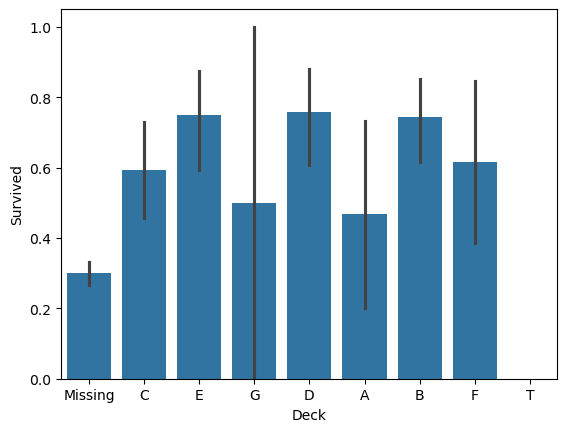

In [27]:
# 觀察不同 Deck 與生還率的關係 (含 Missing)
sns.barplot(x='Deck', y='Survived', data=train)

#### Summary: `Deck` Feature
- `Deck` was extracted from the `Cabin` column to explore cabin location effects.
- Analysis showed:
  - Strong overlap with `Pclass` (e.g., Deck A/B/C = Pclass 1)
  - High missing rate
  - No consistent pattern with survival

**Conclusion:**  
- Not used as a final model feature
- Retained only as part of exploratory analysis, but **excluded from modeling due to redundancy with `Pclass` (e.g., `PremiumCabin`)

### 3.6 `Embarked` (Port of Embarkation)

`Embarked` indicates the port from which the passenger boarded the Titanic. It includes three categories:  
- `S` = Southampton
- `C` = Cherbourg
- `Q` = queenstown

Although seemingly unrealted, the port of embarkation may correlate with passenger class, fare levels, or regional demographics, and is worth evaluating in relation to survival.

In [37]:
# 缺失值檢查
print("Missing values in Embarked:", train['Embarked'].isnull().sum())

# 各港口生還率與樣本數
embarked_summary = train.groupby('Embarked')['Survived'].agg(['mean', 'count']).reset_index()
embarked_summary.columns = ['Embarked', 'SurvivalRate', 'Count']
print(embarked_summary)

Missing values in Embarked: 2
  Embarked  SurvivalRate  Count
0        C      0.553571    168
1        Q      0.389610     77
2        S      0.336957    644


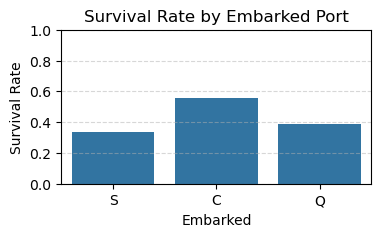

In [57]:
# 視覺化 Embarked 與生還率的關係
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,2))
sns.barplot(data=train, x='Embarked', y='Survived', errorbar=None)
plt.title('Survival Rate by Embarked Port')
plt.ylabel('Survival Rate')
plt.xlabel('Embarked')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

#### Summary:
- Although `Embarked` is a categorical variable, it shows **no clear or stable correlation** with survival.
- Differences in survival rates across ports are largely explained by **Pclass composition**, not by the port itself.
- After evaluating multiple cross-feature interactions:
  - `Embarked × Pclass` proved **statistically unstable** due to small sample sizes
  - Further combinations (e.g. with `FarePerPerson`, `Deck`) were **deemed unnecessary**

**Conclustion:**  
`Embarked` is **excluded from modeling** due to limited predictive value.

## 4. Final Feature Summary & Export

### 4.1 Final Feature Decision Table

|Feature Name|Description|Keep for Modeling|Notes|
|:-|:-|:-|:-|
|`Pclass`|Ticket class (1st, 2nd, 3rd)|Yes|Strong survival conrrelation|
|`Sex`|Gender|Yes|Strong survival correlation|
|`Age`|Age|Optional|Consider imputation or exclusion|
|`FamilySize`|SibSp + Parch + 1|Yes|Basis for `IsAlone` / `FamilyGroup`|
|`IsAlone`|1 if FamilySize == 1|Yes|Useful binary version of FamilySize|
|`FamilyGroup`|Categorized FamilySize (Alone/Small/Large)|Yes|With confidence intervals tested|
|`FarePerPerson`|Fare divided by FamilySize|Yes|Adjusts for shared ticket fares|
|`Deck`|Extracted from Cabin|No|High missing rate, overlaps with `Pclass`|
|`PremiumCabin`|Deck A/B/C → 1, else 0|No|Redundant with `Pclass` == 1|
|`Embarked`|Port of Embarkation|No|No stable correlation, low modeling value|
> Optional: Can be included with imputation if desired, but model impact should be validated.

### 4.2 Selected Features for Modeling

In [65]:
# Final selected features list for Export
selected_features = [
    'Pclass',
    'Sex',
    'FamilySize',
    'IsAlone',
    'FamilyGroup',
    'FarePerPerson',
    'Title_Grouped'
    # 'Age',  # Optional: include if imputed
    # 'Embarked',  # Excluded after evaluation
]

### 4.3 Export Feature-Enhanced Dataset

In [66]:
# Include target column
train_fe = train[selected_features + ['Survived']]

# Export to CSV
train_fe.to_csv('../data/train_fe.csv', index=False)

print("✅ Feature-enhanced training dataset saved as train_fe.csv")


✅ Feature-enhanced training dataset saved as train_fe.csv


### 4.4 Feature Engineering Summary

We finalized a feature set based on predictive value, correlation structure, and cross-feature analysis.  
All included features demonstrated meaningful and stable association with survival.  
Variables like `Deck`, `PremiumCabin`, and `Embarked` were excluded after validation, due to redundancy or lack of signal.  
The resulting dataset is ready for model development.

## 5. Archived

#### `Deck × Pclass × Survival`
- After observing the `Deck × Pclass` cross-analysis, I found that the presence of `Deck` information is associated with the passenger's `Pclass`. Therefore, I further analyze how these two features relate to servival rate.

In [29]:
# 計算 Deck × Pclass × Survived 的人數
deck_pclass_survived = train.groupby(['Deck', 'Pclass'])['Survived'].agg(['count', 'sum', 'mean']).reset_index()
deck_pclass_survived.rename(columns={'sum': 'SurvivedCount', 'mean': 'SurvivalRate'}, inplace=True)

deck_pclass_survived

,Deck,Pclass,count,SurvivedCount,SurvivalRate
0,A,1,15,7,0.466667
1,B,1,47,35,0.744681
2,C,1,59,35,0.593220
3,D,1,29,22,0.758621
4,D,2,4,3,0.750000
5,E,1,25,18,0.720000
6,E,2,4,3,0.750000
7,E,3,3,3,1.000000
8,F,2,8,7,0.875000
9,F,3,5,1,0.200000


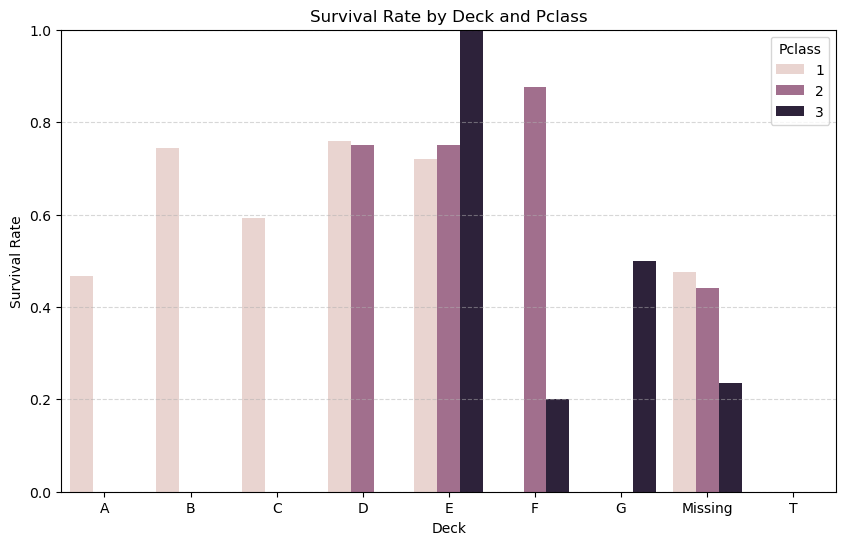

In [30]:
plt.figure(figsize=(10,6))
sns.barplot(data=deck_pclass_survived, x='Deck', y='SurvivalRate', hue='Pclass')
plt.title('Survival Rate by Deck and Pclass')
plt.ylabel('Survival Rate')
plt.xlabel('Deck')
plt.ylim(0, 1)
plt.legend(title='Pclass')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


##### Removed Analysis: `Deck × Pclass × Survival`

This visualization was intended to explore the relationship between deck level, passenger class, and survival rate. However, after reviewing the chart, I found **no meaningful or consistent correlation** between `Pclass` and `Survival Rate` across `Deck`.

Additionally, the distribution of `Pclass` across `Deck` is uneven—most upper `Deck` contain predominantly first-class passengers, making this analysis redundant and potentially misleading.

**Conclusion:** This section is removed to maintain focus on analyses with stronger explanatory power.

#### `Deck` Cross-Features Analysis:

Since `Deck` may be related to both `Pclass` and `FarePerPerson`, I decided to perform cross-feature analysis to explore their interactions.  

- `Deck × Pclass` **(primary)**

  - `Deck` (actual cabin location) and `Pclass` (ticket class) both reflect socio-economic status and were found to be **strongly correlated**.
  - This helps assess redundancy between the two features.
  - Based on this observation, we may consider engineering a simplified feature such as `PremiumCabin`.  


- `Deck × FarePerPerson` **(considered but excluded)**
  - While `FarePerPerson` reflects the fare paid per passenger and could theoretically correlate with `Deck`, it was deemed **redundant** given the already strong relationship between `Deck` and `Pclass`, and between `Pclass` and `Fare`.
  - Therefore, `Deck × FarePerPerson` analysis was **not pursued further** to avoid overlapping insights and maintain clarity in feature exploration.

##### `Deck × Pclass`

In [31]:
# 建立 Deck × Pclass 的人數交叉表
cross_counts = train.groupby(['Deck', 'Pclass']).size().unstack(fill_value=0)

# 顯示交叉表
cross_counts

Pclass,1,2,3
Deck,,,
A,15,0,0
B,47,0,0
C,59,0,0
D,29,4,0
E,25,4,3
F,0,8,5
G,0,0,4
Missing,40,168,479
T,1,0,0


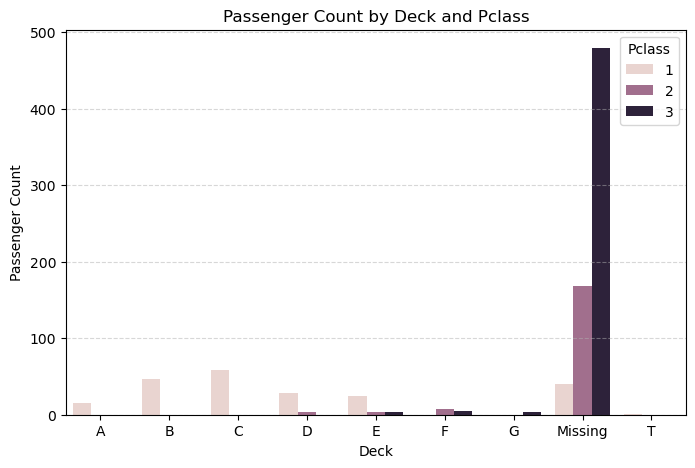

In [32]:
# 視覺化堆疊條圖
import matplotlib.pyplot as plt

# 重新整理資料格式為長格式，方便 Seaborn 繪圖
cross_df = train.groupby(['Deck', 'Pclass']).size().reset_index(name='count')

# 畫出 Deck × Pclass 的堆疊圖
import seaborn as sns
plt.figure(figsize=(8,5))
sns.barplot(data=cross_df, x='Deck', y='count', hue='Pclass')
plt.title('Passenger Count by Deck and Pclass')
plt.xlabel('Deck')
plt.ylabel('Passenger Count')
plt.legend(title='Pclass')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


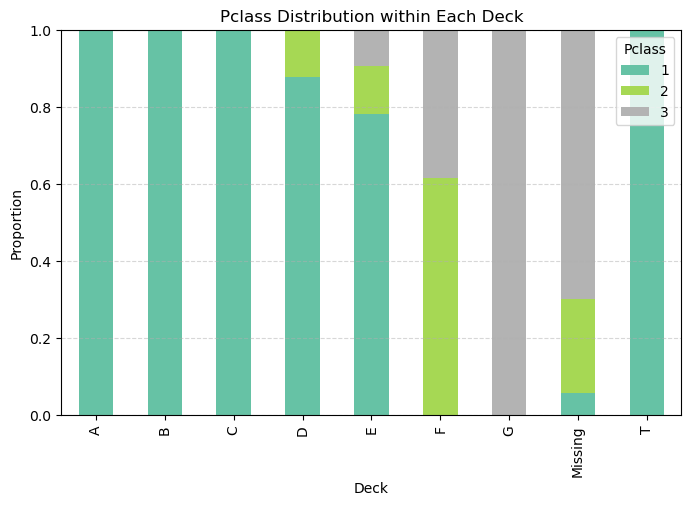

In [33]:
# 每個 Deck 中，各個 Pclass 所佔比例 (百分比堆疊圖)
# 計算比例
deck_pclass_pct = cross_counts.div(cross_counts.sum(axis=1), axis=0)

# 畫出百分比堆疊圖
deck_pclass_pct.plot(kind='bar', stacked=True, figsize=(8,5), colormap='Set2')
plt.title('Pclass Distribution within Each Deck')
plt.xlabel('Deck')
plt.ylabel('Proportion')
plt.legend(title='Pclass')
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

#### 3.5-1 `PremiumCabin`

During previous `Deck × Pclass` analysis, I observed that most passengers with a known `Deck` belonged to **Pclass 1**, suggesting that deck information was more often recorede for **upper-class passengers**.  
This led to the hypothesis that **passengers located on higher decks (Deck A, B, or C)** might have better access to lifeboats or crew assistance, which could contribute to a higher survival rate.  
To explore this, I engineered a new binary feature called `PremiumCabin`:  
- `PremiumCabin = 1` if `Deck` is A, B, or C
- `PremiumCabin = 0` otherwise (including missing decks)

I then compared survival rates between the two groups to assess whether **deck-level access** is associated with **survival probability**, beyond what `Pclass` or `Fare` may already capture.

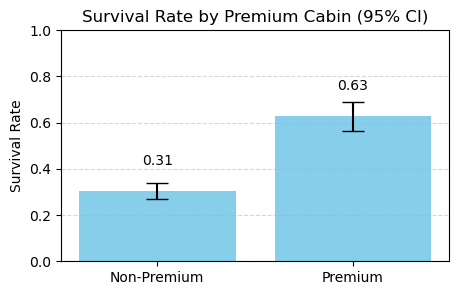

In [34]:
# 建立 PremiumCabin
train['PremiumCabin'] = ((train['Deck'].notna()) & (train['Pclass'] == 1)).astype(int)

# 計算 PremiumCabin 與生還了率的關係 (含 95% 信賴區間)
from statsmodels.stats.proportion import proportion_confint

# 計算生還統計
premium_group = train.groupby('PremiumCabin')['Survived'].agg(['sum', 'count']).reset_index()
premium_group['rate'] = premium_group['sum'] / premium_group['count']

# 加入信賴區間
premium_group['lower_ci'], premium_group['upper_ci'] = proportion_confint(
    count=premium_group['sum'],
    nobs=premium_group['count'],
    alpha=0.05,
    method='wilson'
)

# 繪製生還率直條圖 (含信賴區間)
import matplotlib.pyplot as plt

# 計算誤差條
error_lower = premium_group['rate'] - premium_group['lower_ci']
error_upper = premium_group['upper_ci'] - premium_group['rate']

# 繪圖
plt.figure(figsize=(5, 3))
plt.bar(x=[0, 1], height=premium_group['rate'], 
        yerr=[error_lower, error_upper],
        capsize=8, color='skyblue')

plt.xticks([0, 1], ['Non-Premium', 'Premium'])
plt.ylabel('Survival Rate')
plt.title('Survival Rate by Premium Cabin (95% CI)')
plt.ylim(0, 1)

# 加入數值標籤
for index, row in premium_group.iterrows():
    plt.text(index, row['rate'] + 0.1, f"{row['rate']:.2f}", ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

#### `PremiumCabin` Cross-Feature Analysis

`PremiumCabin × Pclass`  
- To check: Is `PremiumCabin` just a proxy for `Pclass`?

In [35]:
pd.crosstab(train['PremiumCabin'], train['Pclass'], normalize='index')

Pclass,1,2,3
PremiumCabin,,,
0,0.0,0.272593,0.727407
1,1.0,0.000000,0.000000


##### Summary:
`PremiumCabin` is **not an independent source of information**, but rather a direct alias for `Pclass == 1`.  

**Conclusion:**  
**Keep** `Pclass` and **drop** `PremiumCabin`, as `Pclass` preserves the full three-tier cabin calss structure (1st, 2nd, and 3rd).

#### `Embarked` Cross-Features Analysis

In analyzing the relationship between `Embarked` and `Survived`, I observed that passengers who embarked from port `C` (Cherbourg) had a notably higher survival rate. This raises the need to explore potential underlying factors.  
To investigate this, I plan the following cross-feature analyses:
- `Embarked × Pclass × Survival` : to check whether the high survival rate at port `C` is driven by a higher proportion of first-class passengers.
- `Embarked × FarePerPerson × Survival` : to see if passengers from port C generally paid higher fares, which may indicate higher socio-economic status.
- `Embarked × Deck × Survival` : to explore whether cabin location (`Deck`) is involved. However, due to a high number of missing `Deck` values, this will be considered last.

In [43]:
# 建立交叉生還率表格
embarked_pclass_survival = train.pivot_table(
    values='Survived',
    index='Embarked',
    columns='Pclass',
    aggfunc='mean'
).round(2)

print(embarked_pclass_survival)

Pclass       1     2     3
Embarked                  
C         0.69  0.53  0.38
Q         0.50  0.67  0.38
S         0.58  0.46  0.19


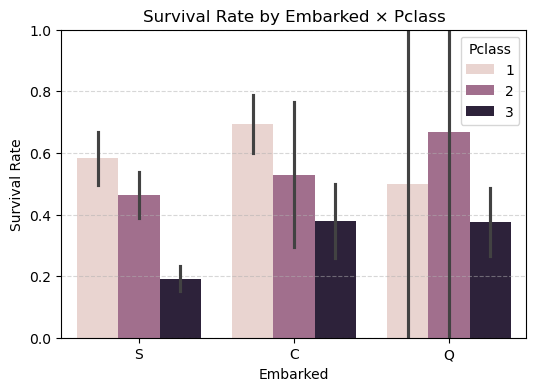

In [49]:
# 視覺化 Embarked × Pclass × Survived 的關係
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.barplot(data=train, x='Embarked', y='Survived', hue='Pclass')
plt.title('Survival Rate by Embarked × Pclass')
plt.ylabel('Survival Rate')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

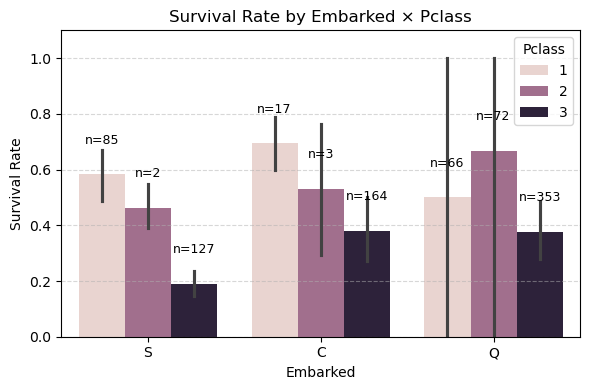

In [55]:
# 於圖表中增加顯示每個 bar 上面的樣本數
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 計算每組的樣本數和生還率
grouped = train.groupby(['Embarked', 'Pclass'])['Survived'].agg(['mean', 'count']).reset_index()

plt.figure(figsize=(6, 4))
ax = sns.barplot(data=train, x='Embarked', y='Survived', hue='Pclass')

# 加上樣本數標籤
for bars, (_, group) in zip(ax.containers, grouped.groupby('Embarked')):
    for bar, (_, row) in zip(bars, group.iterrows()):
        height = bar.get_height()
        count = row['count']
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            height + 0.1, 
            f'n={int(count)}', 
            ha='center', va='bottom', fontsize=9, color='black'
        )

# 圖表設定
plt.title('Survival Rate by Embarked × Pclass')
plt.ylabel('Survival Rate')
plt.xlabel('Embarked')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Pclass')
plt.tight_layout()
plt.show()

##### Summary:
- Although Port `C` (Cherbourg) shows a higher overall survival rate, it is driven by a **very small sample of Pclass 1 passengers (n=17)**.
- Pclass 2 at Port `C` has only **3 observations**, making survival rates **statistically unreliable**.
- The survival pattern is **dominated by Pclass**, not Embarked. The observed trend is **largely redundant**.

**Conclusion:**  
- `Embarked × Pclass` provides **no meaningful or stable value for modeling**.
- Given the lack of meaningful signal in `Embarked × Pclass`, and the high redundancy or sparsity of related features, we recommend **not proceeding with further Embarked-based cross-feature analyses**.